1.Store the related data of 7 labels into a dictionary.

In [ ]:
# Step 1: Get data
from google.colab import drive
drive.mount('/content/drive')

labels = ["danger_running-in_school","play_basketball_alone-in_school","play_basketball_with_kid-in_school","running-in_school","walking-in_school","walking_at_7_foor-in_school","walking_while_using_iphone-in_school"]
google_drive_path = "/content/drive/MyDrive/Colab Notebooks/Human Signals-Final Project/data/"
data_type=["sensor_log_data","sound_data"]

# key:label ex:danger_running-in_school value:["data1_path"]
my_data_set = {}

for label in labels:
  all_data = []
  accelerometer_data_path = google_drive_path + "sensor_log_data" + "/" + label+ "/" + "Accelerometer.csv"
  barometer_data_path = google_drive_path + "sensor_log_data" + "/" + label+ "/" + "Barometer.csv"
  sound_data_path = google_drive_path + "sound_data" + "/" + label + ".m4a"
  all_data.append(accelerometer_data_path)
  all_data.append(barometer_data_path)
  all_data.append(sound_data_path)
  my_data_set[label] = all_data


print(my_data_set.keys())




Mounted at /content/drive
dict_keys(['danger_running-in_school', 'play_basketball_alone-in_school', 'play_basketball_with_kid-in_school', 'running-in_school', 'walking-in_school', 'walking_at_7_foor-in_school', 'walking_while_using_iphone-in_school'])


In [ ]:
print(my_data_set["danger_running-in_school"])

['/content/drive/MyDrive/Colab Notebooks/Human Signals-Final Project/data/sensor_log_data/danger_running-in_school/Accelerometer.csv', '/content/drive/MyDrive/Colab Notebooks/Human Signals-Final Project/data/sensor_log_data/danger_running-in_school/Barometer.csv', '/content/drive/MyDrive/Colab Notebooks/Human Signals-Final Project/data/sound_data/danger_running-in_school.m4a']


In [ ]:
# TEST all File can Read

import os

# Initialize a counter
total_files_read = 0

for label in labels:
    data_paths = my_data_set[label]
    for data_path in data_paths:
        if os.path.exists(data_path):
            print(f"✅ File found: {data_path}")
            try:
                with open(data_path, 'rb') as f:
                    content = f.read()
                print("✅ File read successfully!")
                total_files_read += 1  # Increment the counter after successful reading
            except Exception as e:
                print(f"⚠️ An error occurred while reading the file: {e}")
        else:
            print(f"❌ File not found: {data_path}")

print(f"\n📊 Total files successfully read: {total_files_read}")


✅ File found: /content/drive/MyDrive/Colab Notebooks/Human Signals-Final Project/data/sensor_log_data/danger_running-in_school/Accelerometer.csv
✅ File read successfully!
✅ File found: /content/drive/MyDrive/Colab Notebooks/Human Signals-Final Project/data/sensor_log_data/danger_running-in_school/Barometer.csv
✅ File read successfully!
✅ File found: /content/drive/MyDrive/Colab Notebooks/Human Signals-Final Project/data/sound_data/danger_running-in_school.m4a
✅ File read successfully!
✅ File found: /content/drive/MyDrive/Colab Notebooks/Human Signals-Final Project/data/sensor_log_data/play_basketball_alone-in_school/Accelerometer.csv
✅ File read successfully!
✅ File found: /content/drive/MyDrive/Colab Notebooks/Human Signals-Final Project/data/sensor_log_data/play_basketball_alone-in_school/Barometer.csv
✅ File read successfully!
✅ File found: /content/drive/MyDrive/Colab Notebooks/Human Signals-Final Project/data/sound_data/play_basketball_alone-in_school.m4a
✅ File read successfully!

### Create a function to merge Accelerometer and Barometer CSV files.

In [ ]:
def merge_accel_baro_data(accelerometer_path, barometer_path):
    """
    This function merges accelerometer and barometer data based on the 'seconds_elapsed' column.

    Parameters:
    accelerometer_path (str): Path to the accelerometer data CSV file.
    barometer_path (str): Path to the barometer data CSV file.

    Returns:
    pd.DataFrame: Merged DataFrame containing accelerometer data and corresponding barometer data.
    """
    # Read accelerometer and barometer data
    accel_df = pd.read_csv(accelerometer_path)
    baro_df = pd.read_csv(barometer_path)

    # Sort data by seconds_elapsed to ensure proper merging
    accel_df = accel_df.sort_values('seconds_elapsed').reset_index(drop=True)
    baro_df = baro_df.sort_values('seconds_elapsed').reset_index(drop=True)

    # Prepare a list to store matched barometer values
    baro_idx = 0
    baro_altitudes = []
    baro_pressures = []

    # For each accelerometer record, find the most recent barometer reading
    for _, row in accel_df.iterrows():
        while (baro_idx + 1 < len(baro_df)) and (baro_df.loc[baro_idx + 1, 'seconds_elapsed'] <= row['seconds_elapsed']):
            baro_idx += 1
        baro_altitudes.append(baro_df.loc[baro_idx, 'relativeAltitude'])
        baro_pressures.append(baro_df.loc[baro_idx, 'pressure'])

    # Add new columns to the accelerometer DataFrame
    accel_df['relativeAltitude'] = baro_altitudes
    accel_df['pressure'] = baro_pressures

    return accel_df

### TEST merge_accel_baro_data FUNC

In [ ]:
import pandas as pd

label = "danger_running-in_school"
accelerometer_path = my_data_set[label][0]
barometer_path = my_data_set[label][1]

merge_df = merge_accel_baro_data(accelerometer_path, barometer_path)

label_name , location = label.split("-", 1)  # Split label into location and label_name
merge_df['location'] = location
merge_df['activity'] = label_name


# Save the merged data to a new CSV file
google_drive_path = "/content/drive/MyDrive/Colab Notebooks/Human Signals-Final Project/data/"
merge_df.to_csv(google_drive_path+'test_merged_accel_baro.csv', index=False)

print("Merged file saved as 'test_merged_accel_baro.csv'")

Merged file saved as 'merged_accel_baro.csv'


### ADD a Feature acceleration_magnitude

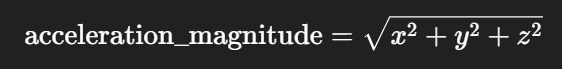

In [ ]:
import pandas as pd
import numpy as np

def add_acceleration_magnitude(df):
    """
    Add a new column 'acceleration_magnitude' to the DataFrame.
    The DataFrame must contain 'x', 'y', and 'z' columns.
    """
    # Check if the necessary columns exist
    if not {'x', 'y', 'z'}.issubset(df.columns):
        raise ValueError("DataFrame must contain 'x', 'y', and 'z' columns")

    # Calculate the magnitude of acceleration
    df['acceleration_magnitude'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
    return df

In [ ]:
import pandas as pd

# Initialize an empty DataFrame to store the merged data from all labels
all_merged_data = pd.DataFrame()

for label in my_data_set.keys():
  accelerometer_path = my_data_set[label][0]
  barometer_path = my_data_set[label][1]

  merge_df = merge_accel_baro_data(accelerometer_path, barometer_path)

  merge_df = add_acceleration_magnitude(merge_df)

  label_name , location = label.split("-", 1)  # Split label into location and label_name
  merge_df['location'] = location
  merge_df['activity'] = label_name

  # Append the merged data to the all_merged_data DataFrame
  all_merged_data = pd.concat([all_merged_data, merge_df], ignore_index=True)


# Save the merged data from all labels to a new CSV file
google_drive_path = "/content/drive/MyDrive/Colab Notebooks/Human Signals-Final Project/data/"
all_merged_data.to_csv(google_drive_path + 'all_sensor_log_features.csv', index=False)

print("Merged file saved as 'all_sensor_log_features.csv'")

Merged file saved as 'all_sensor_log_features.csv'


### Feature extraction from audio data

In [ ]:
!pip install pydub

In [ ]:
import librosa
import numpy as np
import pandas as pd
from pydub import AudioSegment

def extract_audio_features(audio_path, activity_name):
    """
    Extract basic audio features every second from an audio file.
    Add an 'activity' column to indicate the type of activity.
    Returns a DataFrame with one row per second.
    """
    # Load the audio file
    audio = AudioSegment.from_file(audio_path)
    duration_seconds = int(audio.duration_seconds)

    # Convert AudioSegment to raw audio array
    samples = np.array(audio.get_array_of_samples()).astype(np.float32)
    samples /= np.iinfo(audio.array_type).max  # Normalize to [-1, 1]

    # If stereo, take only one channel
    if audio.channels == 2:
        samples = samples[::2]

    sr = audio.frame_rate  # Sampling rate

    feature_rows = []

    for i in range(duration_seconds):
        start_sample = int(i * sr)
        end_sample = int((i + 1) * sr)
        segment = samples[start_sample:end_sample]

        if len(segment) == 0:
            continue

        # Extract features
        rms = np.mean(librosa.feature.rms(y=segment))  # Root Mean Square Energy
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=segment, sr=sr))  # Spectral Centroid
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=segment))  # Zero Crossing Rate
        mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=5)
        mfccs_mean = np.mean(mfccs, axis=1)  # Take mean of each MFCC

        # Prepare the feature dictionary
        feature_dict = {
            'seconds_elapsed': i,
            'rms': rms,
            'spectral_centroid': spectral_centroid,
            'zcr': zcr,
            'activity': activity_name  # Add the activity name
        }
        for j, mfcc in enumerate(mfccs_mean):
            feature_dict[f'mfcc_{j+1}'] = mfcc

        feature_rows.append(feature_dict)

    return pd.DataFrame(feature_rows)


### Combine all audio features into a single CSV file

In [ ]:
all_audio_features_list = []
for label in labels:
  activity_name , location = label.split("-", 1)
  audio_path = my_data_set[label][2]
  audio_features_df = extract_audio_features(audio_path, activity_name=activity_name)
  audio_features_df['activity'] = activity_name
  all_audio_features_list.append(audio_features_df)

# Concatenate all DataFrames into one
all_audio_features_df = pd.concat(all_audio_features_list, ignore_index=True)

google_drive_path = "/content/drive/MyDrive/Colab Notebooks/Human Signals-Final Project/data/"
all_audio_features_df.to_csv(google_drive_path+'all_audio_features.csv', index=False)
print("File saved as 'all_audio_features.csv")

File saved as 'all_audio_features.csv


In [ ]:
import pandas as pd

# Read the CSV files into DataFrames
google_drive_path = "/content/drive/MyDrive/Colab Notebooks/Human Signals-Final Project/data/"
audio_features_df = pd.read_csv(google_drive_path+'all_audio_features.csv')
sensor_log_df = pd.read_csv(google_drive_path+'all_sensor_log_features.csv')

# Set 'seconds_elapsed' as the index for audio_features_df
audio_features_df = audio_features_df.set_index('seconds_elapsed')

# Reset the index so that 'seconds_elapsed' becomes a regular column again
audio_features_df = audio_features_df.reset_index()

# Use reindexing + interpolation or nearest match
sensor_log_df['seconds_elapsed_rounded'] = sensor_log_df['seconds_elapsed'].round()

# Align audio features to the nearest seconds by 'seconds_elapsed'
merged_df = sensor_log_df.merge(
    audio_features_df,
    left_on=['seconds_elapsed_rounded', 'activity'],
    right_on=['seconds_elapsed', 'activity'],  # Merge on 'seconds_elapsed' and 'activity'
    how='left'
)

# Save the merged DataFrame to CSV
merged_df.to_csv(google_drive_path+'all_features.csv', index=False)
print("File saved as 'all_features.csv'")


File saved as 'all_features.csv'
